In [6]:
# Celda 1: Importar librerías y cargar los datos
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
# Cargar los conjuntos de datos
# Asegúrate de que los archivos estén en la misma carpeta que tu notebook, o proporciona la ruta completa.
try:
    # Cargar archivos CSV
    df_category = pd.read_csv('DIM_CATEGORY (2).csv')
    df_sales = pd.read_csv('FACT_SALES (1).csv')
    
    # Cargar archivos Excel (.xlsx)
    df_segment = pd.read_excel('DIM_SEGMENT (1).xlsx')
    df_calendar = pd.read_excel('DIM_CALENDAR (2).xlsx')
    df_product = pd.read_excel('DIM_PRODUCT (1).xlsx')
    
    print("Todos los archivos se cargaron exitosamente. ✅")

except FileNotFoundError as e:
    print(f"Error ❌: No se encontró el archivo {e.filename}. Asegúrate de que el nombre y la ruta son correctos.")
except Exception as e:
    print(f"Ocurrió un error al leer los archivos: {e}")

Todos los archivos se cargaron exitosamente. ✅


In [7]:
# Celda 2: Unificar los DataFrames y filtrar por la marca 'VANISH'

# Fusionar ventas con calendario
df_sales_calendar = pd.merge(df_sales, df_calendar, on='WEEK', how='left')

# Fusionar productos con categorías
df_product.rename(columns={'CATEGORY': 'ID_CATEGORY'}, inplace=True)
df_product_category = pd.merge(df_product, df_category, on='ID_CATEGORY', how='left')

# Limpiar códigos de producto y fusionar ventas con productos
df_sales_calendar['ITEM_CODE_CLEAN'] = df_sales_calendar['ITEM_CODE'].str.replace('BP2', '', regex=False)
df_merged = pd.merge(df_sales_calendar, df_product_category, left_on='ITEM_CODE_CLEAN', right_on='ITEM', how='inner')

# Fusionar con segmentos
df_segment.rename(columns={'CATEGORY': 'ID_CATEGORY'}, inplace=True)
df_final = pd.merge(df_merged, df_segment, on=['ID_CATEGORY', 'ATTR1', 'ATTR2', 'ATTR3', 'FORMAT'], how='left')

# Seleccionar columnas relevantes
df_final = df_final[['YEAR', 'MONTH', 'REGION', 'MANUFACTURER', 'BRAND', 'ITEM_DESCRIPTION', 'CATEGORY', 'SEGMENT', 'TOTAL_VALUE_SALES']]

# Filtrar solo por la marca 'VANISH' y crear una copia para evitar advertencias
df_vanish = df_final[df_final['BRAND'] == 'VANISH'].copy()

print("--- DataFrame de Vanish listo para el análisis ---")
df_vanish.head()

--- DataFrame de Vanish listo para el análisis ---


,YEAR,MONTH,REGION,MANUFACTURER,BRAND,ITEM_DESCRIPTION,CATEGORY,SEGMENT,TOTAL_VALUE_SALES
0,2022,8,TOTAL AUTOS AREA 5,RECKITT,VANISH,VANISH OXI ACTION GOLD QUITAMANCHAS BOLSA 1.8K...,FABRIC TREATMENT and SANIT\r\n,POWDER,116.519
1,2022,8,TOTAL AUTOS AREA 5,RECKITT,VANISH,VANISH OXI ACTION ROSA QUITAMANCHAS DOYPACK 24...,FABRIC TREATMENT and SANIT\r\n,POWDER,68.453
2,2022,8,TOTAL AUTOS AREA 5,RECKITT,VANISH,VANISH OXI ACTION GOLD QUITAMANCHA AHORRO DEL ...,FABRIC TREATMENT and SANIT\r\n,POWDER,1.481
3,2022,8,TOTAL AUTOS AREA 5,RECKITT,VANISH,VANISH INTELLIGENCE POLVO BOTE 450 GR NAL 7501...,FABRIC TREATMENT and SANIT\r\n,POWDER,182.839
4,2022,8,TOTAL AUTOS AREA 5,RECKITT,VANISH,VANISH OXI ACTION ROSA QUITA/MANCHAS P/ROPA BO...,FABRIC TREATMENT and SANIT\r\n,POWDER,0.679


In [8]:
# Celda 3: Agrupar, preparar y estandarizar las características

# 1. Agrupar datos para la segmentación de mercados
df_segmentation = df_vanish.groupby(['REGION', 'CATEGORY', 'SEGMENT'])['TOTAL_VALUE_SALES'].sum().reset_index()

# 2. Convertir variables categóricas a numéricas (One-Hot Encoding)
df_encoded = pd.get_dummies(df_segmentation, columns=['REGION', 'CATEGORY', 'SEGMENT'])

# 3. Estandarizar todas las características para el modelo
scaler = StandardScaler()
features_scaled = scaler.fit_transform(df_encoded)

print("--- Datos transformados y estandarizados (primeras 5 filas) ---")
print(pd.DataFrame(features_scaled, columns=df_encoded.columns).head())

--- Datos transformados y estandarizados (primeras 5 filas) ---
   TOTAL_VALUE_SALES  REGION_TOTAL AUTOS AREA 1  REGION_TOTAL AUTOS AREA 2  \
0          -0.535755                   2.449490                  -0.408248   
1          -0.135018                   2.449490                  -0.408248   
2          -0.345956                   2.449490                  -0.408248   
3          -0.617697                   2.449490                  -0.408248   
4          -0.397137                  -0.408248                   2.449490   

   REGION_TOTAL AUTOS AREA 3  REGION_TOTAL AUTOS AREA 4  \
0                  -0.408248                  -0.408248   
1                  -0.408248                  -0.408248   
2                  -0.408248                  -0.408248   
3                  -0.408248                  -0.408248   
4                  -0.408248                  -0.408248   

   REGION_TOTAL AUTOS AREA 5  REGION_TOTAL AUTOS AREA 6  \
0                  -0.408248                  -0.4082

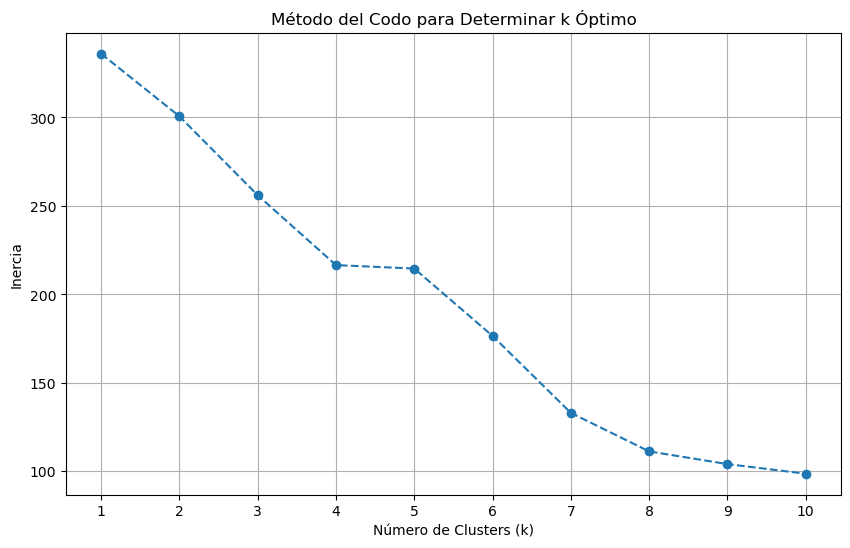

In [9]:
# Celda 4: Determinar el número óptimo de clusters con el Método del Codo

inertia = []
k_range = range(1, 11)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Método del Codo para Determinar k Óptimo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.xticks(k_range)
plt.grid(True)
plt.show()

In [10]:
# Celda 5: Aplicar K-Means y analizar los resultados

# El codo se observa en k=4, por lo que será nuestro número de clusters
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)

# Asignar cada segmento a un cluster
df_segmentation['Cluster'] = kmeans.fit_predict(features_scaled)

print("--- Análisis Descriptivo de Ventas por Cluster ---")
cluster_analysis = df_segmentation.groupby('Cluster')['TOTAL_VALUE_SALES'].describe()
print(cluster_analysis)

--- Análisis Descriptivo de Ventas por Cluster ---
         count           mean            std        min         25%  \
Cluster                                                               
0          7.0  100917.715857  113788.402333  35548.220  45598.8555   
1          7.0  166867.577714  187370.684604  60905.168  73491.9515   
2          7.0    7749.393857    8780.151499   2699.848   3008.2335   
3          7.0   33007.945571   36885.860365  12732.436  14306.7250   

                50%          75%         max  
Cluster                                       
0         55009.604   85728.2380  353212.000  
1        100506.316  137820.5800  584036.497  
2          3739.197    7333.6860   27122.873  
3         20952.123   26614.9245  115527.761  


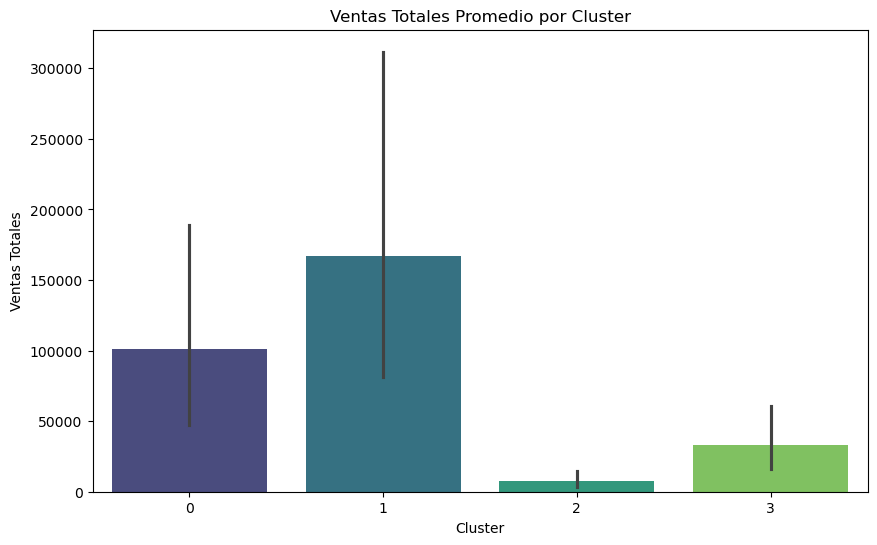

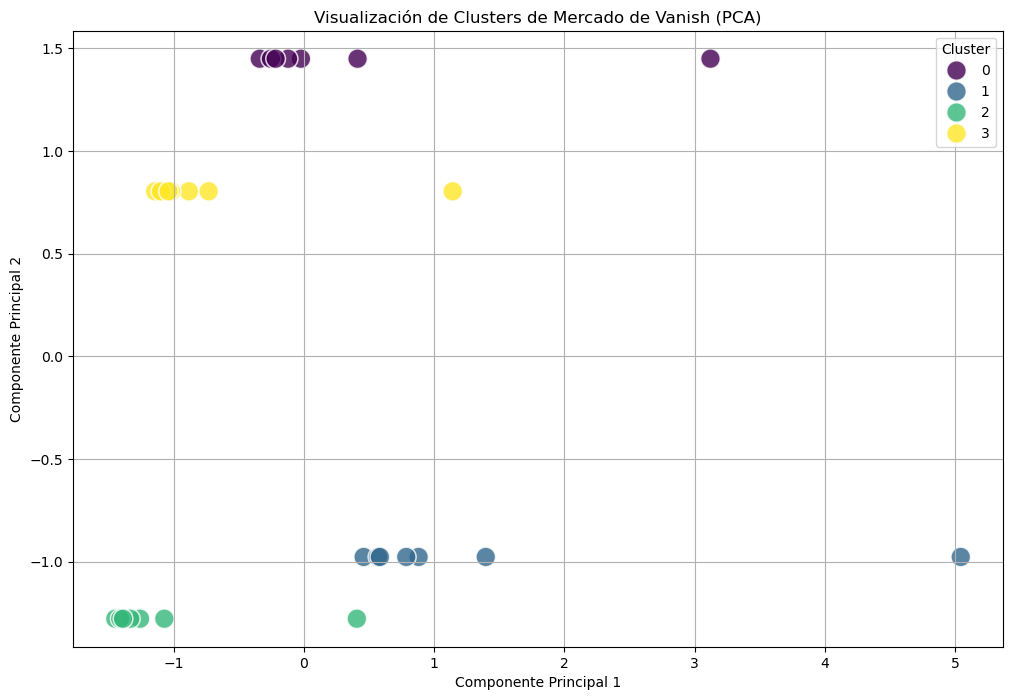

In [11]:
# Celda 6: Visualizar los clusters

# Gráfico de Barras: Ventas Totales Promedio por Cluster
plt.figure(figsize=(10, 6))
sns.barplot(x='Cluster', y='TOTAL_VALUE_SALES', data=df_segmentation, palette='viridis')
plt.title('Ventas Totales Promedio por Cluster')
plt.ylabel('Ventas Totales')
plt.xlabel('Cluster')
plt.show()

# Visualización con PCA para reducir la dimensionalidad a 2D
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)
df_segmentation['PCA1'] = features_pca[:, 0]
df_segmentation['PCA2'] = features_pca[:, 1]

# Gráfico de dispersión de los clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PCA1', y='PCA2', hue='Cluster', data=df_segmentation, palette='viridis', s=200, alpha=0.8)
plt.title('Visualización de Clusters de Mercado de Vanish (PCA)')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.legend(title='Cluster')
plt.grid(True)
plt.show()

In [12]:
# Celda 7: Guardar los resultados finales en un archivo CSV

df_segmentation.to_csv('vanish_resultados_clustering.csv', index=False)
print("Resultados del clustering guardados exitosamente en 'vanish_resultados_clustering.csv'")

Resultados del clustering guardados exitosamente en 'vanish_resultados_clustering.csv'
